In [11]:
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from PIL import Image
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

DATA_PATH = "dataset/"

In [2]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
meta_df = pd.read_csv(f"{DATA_PATH}Meta.csv")
train_df = pd.read_csv(f"{DATA_PATH}Train.csv")
test_df = pd.read_csv(f"{DATA_PATH}Test.csv")

In [4]:
## Input data size
image_width = 30
image_height = 30
channels = 3  # RGB

In [5]:
num_classes = len(meta_df["ClassId"].value_counts())
num_classes

43

In [6]:
## load train data
data = []
labels = []

for i in range(num_classes):
    train_path = f"{DATA_PATH}Train/{i}"
    images = os.listdir(train_path)  # all images of the i-th class

    for image_path in images:
        image = cv2.imread(f"{train_path}/{image_path}")
        image_from_array = Image.fromarray(image, "RGB")
        resized_image = image_from_array.resize((image_height, image_width))
        data.append(np.array(resized_image))
        labels.append(i)  # image directories are divided by label, use index as label

data = np.array(data) / 255
labels = np.array(labels)

In [7]:
## Split into training and validation split
X_train, X_val, y_train, y_val = train_test_split(
    data, labels, test_size=0.2, shuffle=True, random_state=42
)

In [8]:
## Model creation
model = keras.models.Sequential(
    [
        keras.layers.Conv2D(
            filters=16,
            kernel_size=(3, 3),
            activation="relu",
            input_shape=(image_height, image_width, channels),
        ),
        keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPool2D(pool_size=(2, 2)),
        keras.layers.BatchNormalization(axis=-1),
        keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu"),
        keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPool2D(pool_size=(2, 2)),
        keras.layers.BatchNormalization(axis=-1),
        keras.layers.Flatten(),
        keras.layers.Dense(512, activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(rate=0.5),
        keras.layers.Dense(num_classes, activation="softmax"),
    ]
)

In [9]:
## training parameters
lr = 0.001
numEpochs = 30
optimizer = Adam(learning_rate=lr, decay=lr / (numEpochs * 0.5))
batch_size = 16
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=optimizer,
    metrics=["accuracy"],
)

In [10]:
## Data augmentation
augmentation = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
)

augmented_data = augmentation.flow(X_train, y_train, batch_size=batch_size)

In [11]:
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.set_logical_device_configuration(
            gpus[0], [tf.config.LogicalDeviceConfiguration(memory_limit=1024)]
        )
        logical_gpus = tf.config.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

Virtual devices cannot be modified after being initialized


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor="loss", patience=3, restore_best_weights=True
)
history = model.fit(
    augmented_data,
    epochs=numEpochs,
    validation_data=(X_val, y_val),
    callbacks=[callback],
)

In [6]:
labels = test_df["ClassId"].values
images = test_df["Path"].values

data = []

for img in images:
    try:
        path = DATA_PATH + img
        image = cv2.imread(path)
        image_fromarray = Image.fromarray(image, "RGB")
        resize_image = image_fromarray.resize((image_height, image_width))
        data.append(np.array(resize_image))
    except Error as e:
        print(e)
X_test = np.array(data)
X_test = X_test / 255

In [35]:
predictions = model.predict(X_test)
predictions = np.argmax(predictions, axis=1)
# Accuracy with the test data
print("Test Data accuracy: ", accuracy_score(labels, predictions) * 100)

Test Data accuracy:  98.65399841646872


In [7]:
model = tf.keras.models.load_model("trafficSignModel")

In [8]:
predictions = model.predict(X_test)
predictions = np.argmax(predictions, axis=1)
# Accuracy with the test data
print("Test Data accuracy: ", accuracy_score(labels, predictions) * 100)

395/395 [==============================] - 3s 2ms/step
Test Data accuracy:  98.65399841646872


In [19]:
from sklearn.metrics import confusion_matrix

conf = confusion_matrix(labels, predictions)

array([[ 60,   0,   0, ...,   0,   0,   0],
       [  0, 719,   0, ...,   0,   0,   0],
       [  0,   1, 748, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,  88,   0,   0],
       [  0,   0,   0, ...,   0,  60,   0],
       [  0,   0,   0, ...,   0,   2,  88]], dtype=int64)

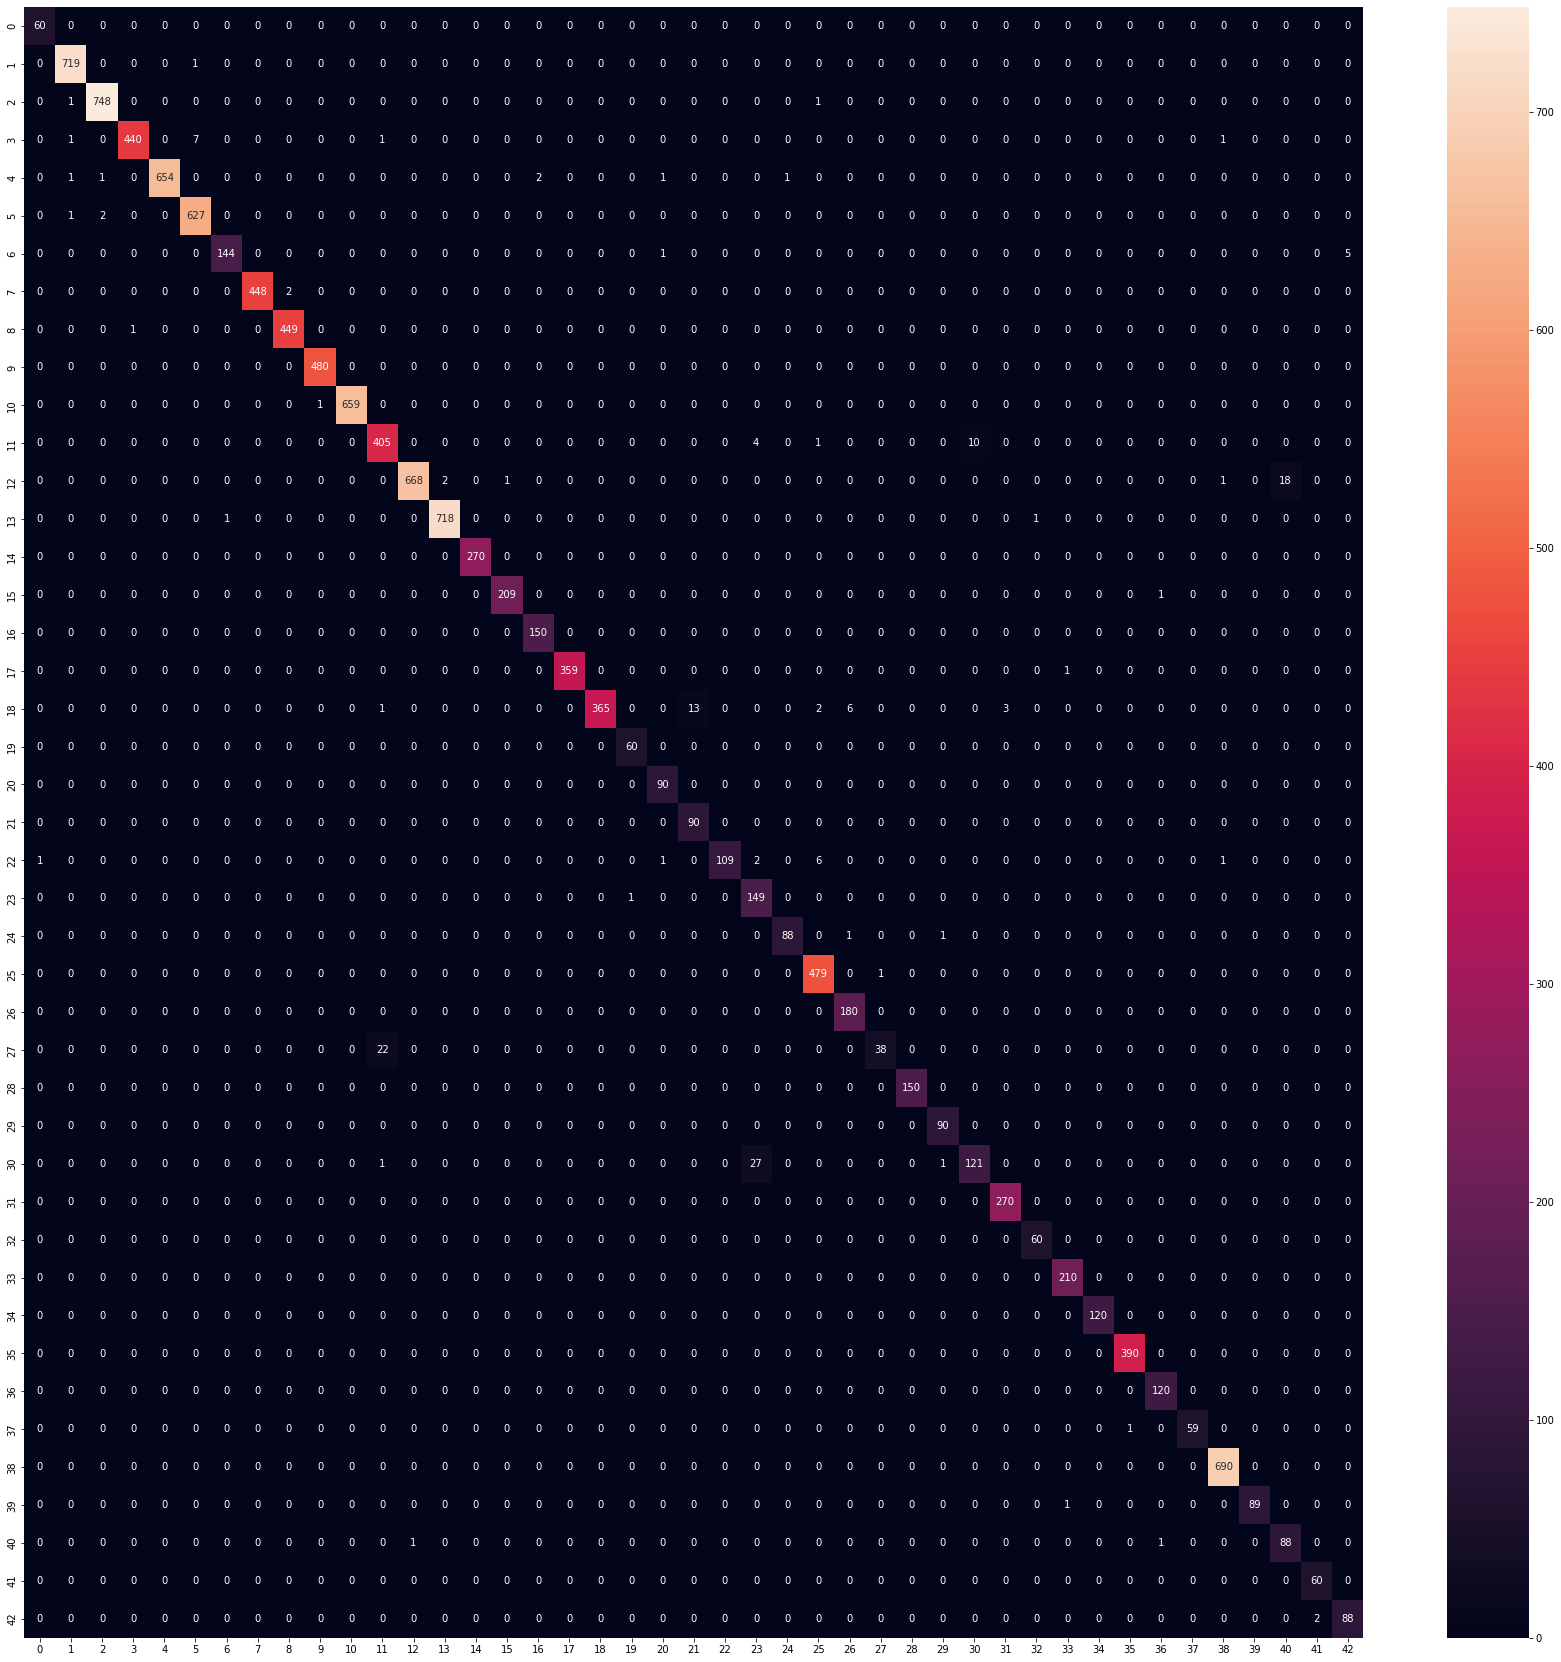

In [24]:
plt.figure(figsize=(30, 30))
sns.heatmap(conf, annot=True, fmt="d")
plt.savefig("conf_matrix.png")

# Model conversion

In [3]:
converter = tf.lite.TFLiteConverter.from_saved_model("trafficSignModel")
tflite_model = converter.convert()

# Save the model.
with open("cnn.tflite", "wb") as f:
    f.write(tflite_model)

In [4]:
## metadata
from tflite_support import flatbuffers
from tflite_support import metadata as _metadata
from tflite_support import metadata_schema_py_generated as _metadata_fb

""" ... """
"""Creates the metadata for an image classifier."""

# Creates model info.
model_meta = _metadata_fb.ModelMetadataT()
model_meta.name = "Traffic sign classifier"
model_meta.description = "Identify German Traffic signs"
model_meta.version = "v1"
model_meta.author = "akletini"
model_meta.license = (
    "Apache License. Version 2.0 " "http://www.apache.org/licenses/LICENSE-2.0."
)

In [5]:
# Creates input info.
input_meta = _metadata_fb.TensorMetadataT()

# Creates output info.
output_meta = _metadata_fb.TensorMetadataT()

In [6]:
input_meta.name = "image"
input_meta.description = (
    "Input image to be classified. The expected image is {0} x {1}, with "
    "three channels (red, blue, and green) per pixel. Each value in the "
    "tensor is a single byte between 0 and 255.".format(30, 30)
)
input_meta.content = _metadata_fb.ContentT()
input_meta.content.contentProperties = _metadata_fb.ImagePropertiesT()
input_meta.content.contentProperties.colorSpace = _metadata_fb.ColorSpaceType.RGB
input_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.ImageProperties
)
input_normalization = _metadata_fb.ProcessUnitT()
input_normalization.optionsType = _metadata_fb.ProcessUnitOptions.NormalizationOptions
input_normalization.options = _metadata_fb.NormalizationOptionsT()
input_normalization.options.mean = [127.5]
input_normalization.options.std = [127.5]
input_meta.processUnits = [input_normalization]
input_stats = _metadata_fb.StatsT()
input_stats.max = [255]
input_stats.min = [0]
input_meta.stats = input_stats

In [7]:
# Creates output info.
output_meta = _metadata_fb.TensorMetadataT()
output_meta.name = "probability"
output_meta.description = "Probabilities of the 43 labels respectively."
output_meta.content = _metadata_fb.ContentT()
output_meta.content.content_properties = _metadata_fb.FeaturePropertiesT()
output_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.FeatureProperties
)
output_stats = _metadata_fb.StatsT()
output_stats.max = [1.0]
output_stats.min = [0.0]
output_meta.stats = output_stats
label_file = _metadata_fb.AssociatedFileT()
label_file.name = os.path.basename("labels.txt")
label_file.description = "Labels for objects that the model can recognize."
label_file.type = _metadata_fb.AssociatedFileType.TENSOR_AXIS_LABELS
output_meta.associatedFiles = [label_file]

In [8]:
# Creates subgraph info.
subgraph = _metadata_fb.SubGraphMetadataT()
subgraph.inputTensorMetadata = [input_meta]
subgraph.outputTensorMetadata = [output_meta]
model_meta.subgraphMetadata = [subgraph]

b = flatbuffers.Builder(0)
b.Finish(model_meta.Pack(b), _metadata.MetadataPopulator.METADATA_FILE_IDENTIFIER)
metadata_buf = b.Output()

In [9]:
populator = _metadata.MetadataPopulator.with_model_file("cnn.tflite")
populator.load_metadata_buffer(metadata_buf)
populator.load_associated_files(["labels.txt"])
populator.populate()

In [10]:
displayer = _metadata.MetadataDisplayer.with_model_file("model.tflite")
export_json_file = "export.json"
json_file = displayer.get_metadata_json()
# Optional: write out the metadata as a json file
with open(export_json_file, "w") as f:
    f.write(json_file)

# Eval

In [16]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

In [17]:
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [52]:
truths = []
for i in range(len(X_test) - 1):
    # Test the model on random input data.
    input_shape = input_details[0]["shape"]
    input_data = X_test[i : i + 1].astype(np.float32)
    interpreter.set_tensor(input_details[0]["index"], input_data)
    interpreter.invoke()
    output_data = np.argmax(interpreter.get_tensor(output_details[0]["index"]))
    if labels[i] == output_data:
        truths.append(1)

In [54]:
print(len(truths) / len(labels))

0.9864608076009501
